# <font color='red'> LSTM on Donorschoose dataset </font>

<img src='https://i.imgur.com/fkQ8nGo.png'>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import all the libraries
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM
import keras
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Flatten, Dropout
from keras.utils import np_utils 
from keras.datasets import mnist 
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence, Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
import numpy as np 
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
# reading preprocessed data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessed_data.csv')

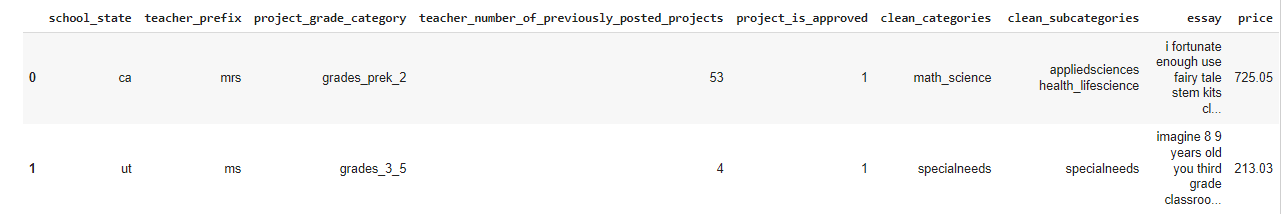

In [ ]:
# performing train test split on the dataset
Y = df['project_is_approved']
X = df.drop('project_is_approved', axis = 1)

In [ ]:
# Further splitting into test and cv
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, random_state = 42, test_size = 0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, random_state = 42, test_size = 0.2)
print(df.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(109248, 9)
(69918, 8) (69918,) (21850, 8) (21850,)


In [ ]:
# Here we are doing padding in order to maintain the same shape of essay features, bcz some essays contains less words as compaered to other
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
X_train_essays = X_train['essay'].values

tokenizer.fit_on_texts(X_train_essays)

train_sequences = tokenizer.texts_to_sequences(X_train_essays)
cv_sequences = tokenizer.texts_to_sequences(X_cv['essay'].values)
test_sequences = tokenizer.texts_to_sequences(X_test['essay'].values)


MAX_SEQUENCE_LENGTH = np.max([len(essay) for essay in train_sequences])

X_padded_essays_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_padded_essays_cv = pad_sequences(cv_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_padded_essays_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

In [ ]:
X_padded_essays_train.shape

(69918, 320)

In [ ]:
# Pre-Trained GloVe Embedding
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())


In [ ]:

from tqdm import tqdm_notebook
GLOVE_VECTOR_DIMENSION = 300

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, GLOVE_VECTOR_DIMENSION))
for word, i in tqdm_notebook(word_index.items()):
    embedding_vector = model.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Word embeddings provide a dense representation of words and their relative meanings. 
# They are an improvement over sparse representations used in simpler bag of word model representations.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/47379 [00:00<?, ?it/s]

In [ ]:
# school_state : categorical data

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)# Fit has to happen only on train data

X_train_school_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer.transform(X_test['school_state'].values)

school_state_features = vectorizer.get_feature_names()

print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 51) (69918,)
(17480, 51) (17480,)
(21850, 51) (21850,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# One hot encoding of Categorical Feature
# clean_categories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)# Fit has to happen only on train data

X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

clean_categories_features = vectorizer.get_feature_names()

print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 9) (69918,)
(17480, 9) (17480,)
(21850, 9) (21850,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# clean_subcategories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)# Fit has to happen only on train data

X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

clean_subcategories_features = vectorizer.get_feature_names()

print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 30) (69918,)
(17480, 30) (17480,)
(21850, 30) (21850,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X_train['project_grade_category'])
# One hot encoding of Categorical Feature
# project_grade_category : categorical data

vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)# Fit has to happen only on train data

X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

project_grade_category_features = vectorizer.get_feature_names()

print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

16528     grades_prek_2
99416        grades_6_8
47276     grades_prek_2
75882       grades_9_12
41540        grades_3_5
              ...      
19040     grades_prek_2
107689    grades_prek_2
60207     grades_prek_2
84364       grades_9_12
97941     grades_prek_2
Name: project_grade_category, Length: 69918, dtype: object
(69918, 4) (69918,)
(17480, 4) (17480,)
(21850, 4) (21850,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
****************************************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# One hot encoding of Categorical Feature
# teacher_prefix : categorical data

print(X_train['teacher_prefix'])
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)# Fit has to happen only on train data

X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_features = vectorizer.get_feature_names()

print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

16528      ms
99416      mr
47276     mrs
75882      mr
41540     mrs
         ... 
19040     mrs
107689     ms
60207      ms
84364      mr
97941     mrs
Name: teacher_prefix, Length: 69918, dtype: object
(69918, 5) (69918,)
(17480, 5) (17480,)
(21850, 5) (21850,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************************************************************************


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
## Preprocessing of numerical features

from sklearn import preprocessing
X_train_numeric = X_train[['teacher_number_of_previously_posted_projects', 'price']].values

# standardization of dependent variables
X_train_numeric = preprocessing.scale(X_train_numeric)
print(X_train_numeric)

X_cv_numeric = X_cv[['teacher_number_of_previously_posted_projects', 'price']].values
X_cv_numeric = preprocessing.scale(X_cv_numeric)

X_test_numeric = X_test[['teacher_number_of_previously_posted_projects', 'price']].values
X_test_numeric = preprocessing.scale(X_test_numeric)
X_test_numeric.shape

[[-0.40445317  4.16454846]
 [ 0.10763013  1.46474502]
 [-0.22156627 -0.15061469]
 ...
 [-0.40445317  0.73026877]
 [ 2.88751089 -0.21731132]
 [-0.36787579 -0.78659141]]


(21850, 2)

In [ ]:
# merging the features: 
from scipy.sparse import hstack

X_train_r = hstack((X_train_school_state_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe,X_train_numeric)).tocsr()
X_cv_r = hstack((X_cv_school_state_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_project_grade_category_ohe, X_cv_teacher_prefix_ohe,X_cv_numeric)).tocsr()
X_test_r = hstack((X_test_school_state_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_project_grade_category_ohe, X_test_teacher_prefix_ohe,X_test_numeric)).tocsr()

print(X_train_r.shape)
print(X_cv_r.shape)
print(X_test_r.shape)

# https://stackoverflow.com/a/19710648/4084039

(69918, 101)
(17480, 101)
(21850, 101)


In [ ]:
# Deep learning models won't work with sparse features, we have to convert them to dense features before fitting in the model.
train=X_train_r.todense()
test = X_test_r.todense()
cv = X_cv_r.todense()

In [ ]:
X_train_r = np.resize(train,new_shape=(69918,101,1))
X_cv_r = np.resize(cv,new_shape=(17480,101,1))
X_test_r = np.resize(test,new_shape=(21850,101,1))

In [ ]:
# ESSAYS LAYER
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Conv1D,BatchNormalization
from keras.models import Model

input_essays = Input(batch_shape=(None,320))

# Word embeddings provide a dense representation of words and their relative meanings. /
# They are an improvement over sparse representations used in simpler bag of word model representations.
x_essays = Embedding(len(word_index) + 1, 
              GLOVE_VECTOR_DIMENSION, 
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable = False)(input_essays)
x_essays = LSTM(10)(x_essays)
x_essays = Flatten()(x_essays)
#lstm_essay_model = Model(input_essays, x_essays)
#lstm_essay_model.summary()


Input2 = Input(shape = (101,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(Input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

#other_input_model = Model(Input2, x2)
#other_input_model.summary()

combined = concatenate([x_essays,x2])


x_combined = Dense(512, activation='relu')(combined)
x_combined = Dropout(0.5)(x_combined)

x_combined = Dense(256, activation='relu')(x_combined)
x_combined = Dropout(0.5)(x_combined)

x_combined = BatchNormalization()(x_combined)

x_combined = Dense(128, activation='relu')(x_combined)
x_combined = Dropout(0.5)(x_combined)
x_combined = Dense(1, activation="sigmoid")(x_combined)

final_model1 = Model([input_essays,Input2],x_combined)
                     

## https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [ ]:
from keras import backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def auc_2(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
#This is for tensorboard callbacks
from keras.callbacks import TensorBoard
import datetime
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"               
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True,mode='auto')                                  
                                                                   
earlystop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)    

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) 

#log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
#tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, write_graph = True,write_grads = True)
callbacks_list = [checkpoint, earlystop] 

In [ ]:
final_model1.compile(loss = 'binary_crossentropy', metrics = ['accuracy',auc_2], optimizer = optimizer)
final_model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 320)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 101, 1)]     0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 320, 300)     14214000    ['input_3[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 99, 64)       256         ['input_4[0][0]']                
                                                                                            

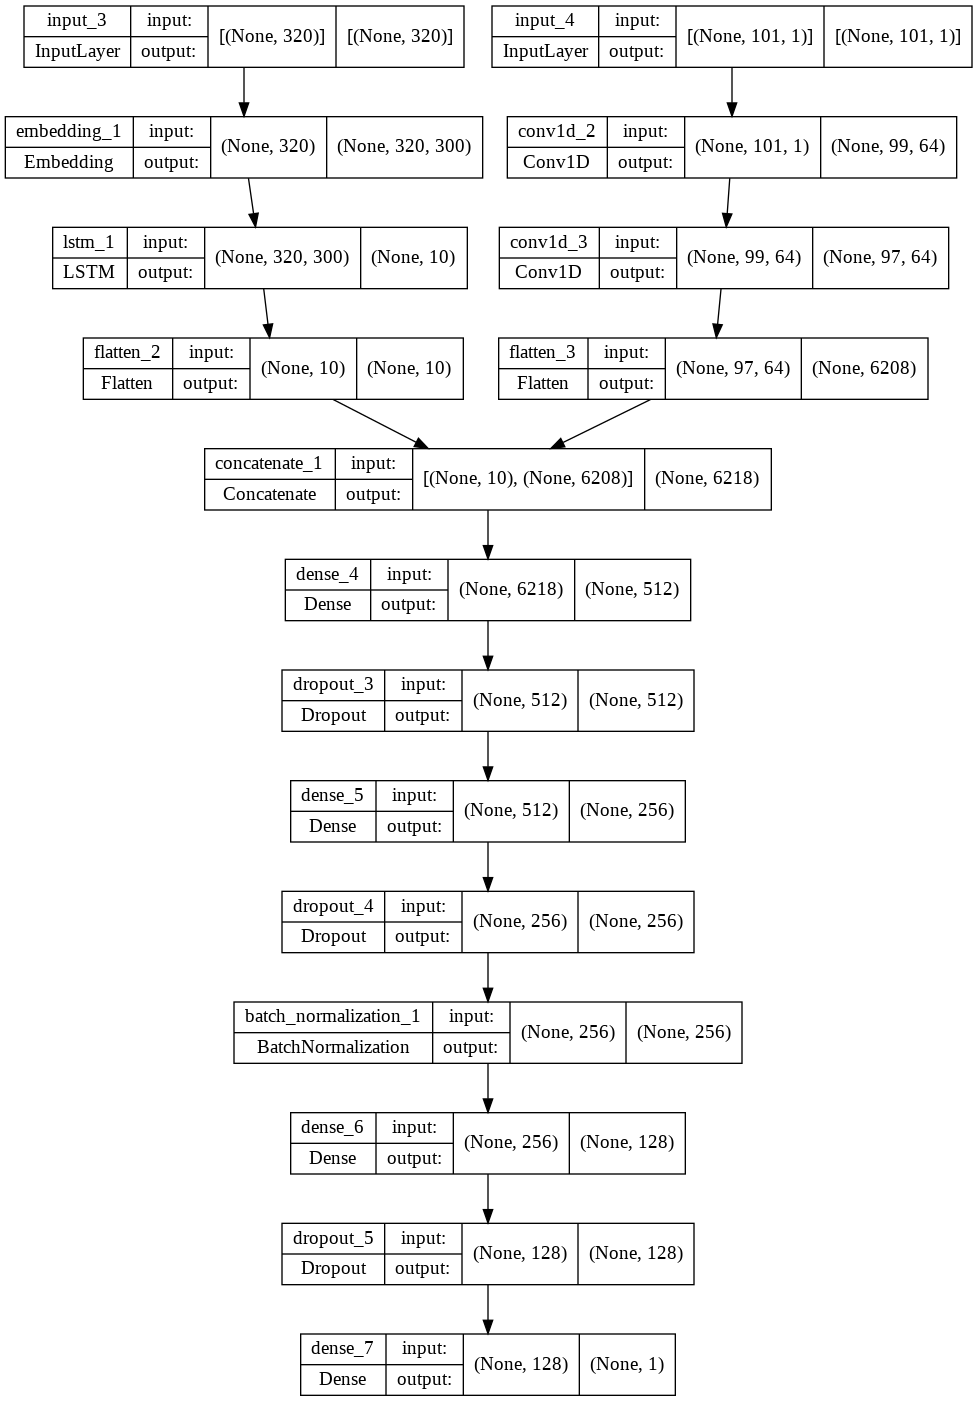

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

from keras.utils.vis_utils import plot_model
plot_model(final_model1, to_file='/content//model_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_padded_essays_train = np.array(X_padded_essays_train)
print(type(X_padded_essays_train))
X_padded_essays_cv = np.array(X_padded_essays_cv)

<class 'numpy.ndarray'>


In [ ]:
final_model1.fit([X_padded_essays_train,X_train_r], y_train,epochs = 10, validation_data=([X_padded_essays_cv, X_cv_r ],y_cv),batch_size = 128, verbose = 1)      

Epoch 1/10
547/547 [==============================] - 43s 75ms/step - loss: 0.4009 - accuracy: 0.8484 - auc_2: 0.6797 - val_loss: 0.3824 - val_accuracy: 0.8490 - val_auc_2: 0.7214
Epoch 2/10
547/547 [==============================] - 41s 74ms/step - loss: 0.3856 - accuracy: 0.8488 - auc_2: 0.7174 - val_loss: 0.3756 - val_accuracy: 0.8526 - val_auc_2: 0.7340
Epoch 3/10
547/547 [==============================] - 40s 74ms/step - loss: 0.3766 - accuracy: 0.8501 - auc_2: 0.7372 - val_loss: 0.3723 - val_accuracy: 0.8520 - val_auc_2: 0.7422
Epoch 4/10
547/547 [==============================] - 40s 74ms/step - loss: 0.3711 - accuracy: 0.8503 - auc_2: 0.7483 - val_loss: 0.3709 - val_accuracy: 0.8519 - val_auc_2: 0.7443
Epoch 5/10
547/547 [==============================] - 40s 73ms/step - loss: 0.3674 - accuracy: 0.8512 - auc_2: 0.7561 - val_loss: 0.3696 - val_accuracy: 0.8498 - val_auc_2: 0.7443
Epoch 6/10
547/547 [==============================] - 41s 74ms/step - loss: 0.3633 - accuracy: 0.851

<built-in method keys of dict object at 0x7f410f157320>


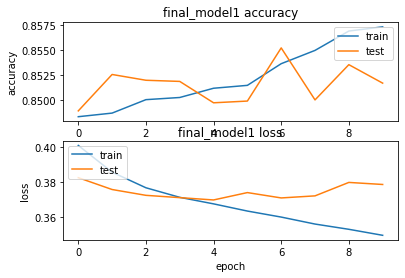

In [ ]:
#list all data in history
print(final_model1.history.history.keys)

import matplotlib.pyplot as plt 

# summarize history for accuracy
plt.subplot(211)
plt.plot(final_model1.history.history['accuracy'])
plt.plot(final_model1.history.history['val_accuracy'])
plt.title('final_model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.show()

# summarize history for loss
plt.subplot(212)
plt.plot(final_model1.history.history['loss'])
plt.plot(final_model1.history.history['val_loss'])
plt.title('final_model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#https://stackoverflow.com/questions/51731207/python-neural-network-typeerror-history-object-is-not-subscriptable
#https://machinelearningmastery.com/display-deep-learning-final_model1-training-history-in-keras/
#https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-final_model1s/

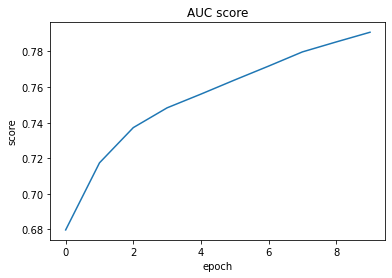

In [ ]:
# AUC plot
plt.plot(final_model1.history.history['auc_2'])
plt.title('AUC score')
plt.ylabel('score')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "AUC"]
x.add_row(['Model 1',0.7492])
x.add_row(['Model 2',0.6804])
x.add_row(['Model 3',0.7441])
print(x)

+---------+--------+
|  Model  |  AUC   |
+---------+--------+
| Model 1 | 0.7492 |
| Model 2 | 0.6804 |
| Model 3 | 0.7441 |
+---------+--------+
